In [46]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import connector
import mysql.connector as mysql_connector

import config

sns.set()
%matplotlib inline

In [47]:
filepath = "dataverse_files"
filename = "Electricity_B1E.csv"

df_origin = pd.read_csv(os.path.join(filepath, filename))
df_origin['unix_ts'] = pd.to_datetime(df_origin['unix_ts'], unit='s')
df_origin.columns = ['timestamp'] + df_origin.columns[1:].to_list()
df_origin.describe()

,V,I,f,DPF,APF,P,Pt,Q,Qt,S,St
count,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06
mean,1.199567e+02,7.414954e-03,6.000440e+01,9.768357e-01,6.703692e-02,1.041284e+00,1.069117e+04,1.990202e-02,9.516987e+02,9.822748e+00,1.037630e+05
std,1.374964e+00,7.161693e-02,1.450046e-01,8.077998e-02,1.755229e-01,8.918983e+00,5.509053e+03,1.971367e-01,6.400277e+02,8.224001e+00,5.355378e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.191000e+02,0.000000e+00,6.000000e+01,1.000000e+00,0.000000e+00,0.000000e+00,5.057000e+03,0.000000e+00,3.850000e+02,9.000000e+00,5.696600e+04
50%,1.200000e+02,0.000000e+00,6.000000e+01,1.000000e+00,5.000000e-02,0.000000e+00,1.190000e+04,0.000000e+00,7.290000e+02,9.000000e+00,1.046270e+05
75%,1.208000e+02,0.000000e+00,6.000000e+01,1.000000e+00,5.000000e-02,0.000000e+00,1.389600e+04,0.000000e+00,1.476000e+03,9.000000e+00,1.490550e+05
max,1.251000e+02,3.300000e+00,6.012000e+01,1.000000e+00,1.000000e+00,6.230000e+02,2.096100e+04,1.500000e+01,2.095000e+03,8.830000e+02,1.969500e+05


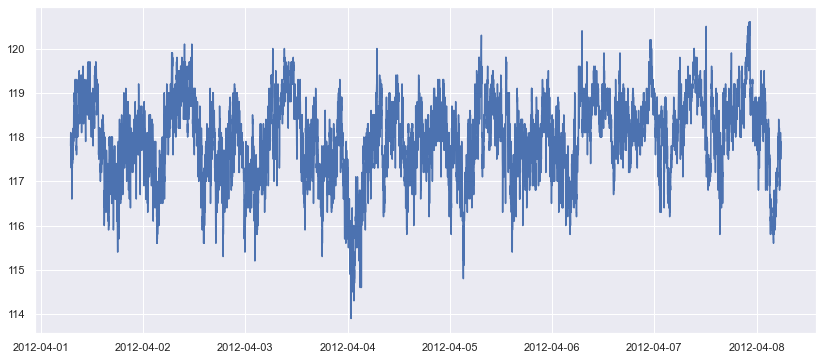

In [48]:
plt.figure(figsize=(14, 6))
plt.plot(df_origin['timestamp'][:10000], df_origin['V'][:10000])

In [49]:
sql_host = config.sql_host
sql_user = config.sql_user
sql_passwd = config.sql_passwd

ourdb = connector.connect(host=sql_host, user=sql_user, passwd=sql_passwd)
ourcursor = ourdb.cursor()

In [50]:
ourcursor.execute('CREATE DATABASE AMPds')
ourcursor.execute('USE AMPds;')

# 1. CREATE TABLE

In [51]:
dev_margin = 0.3

stmt_create_table = (
    "CREATE TABLE voltage ("
    "  id int NOT NULL AUTO_INCREMENT PRIMARY KEY,"
    "  timestamp DATETIME,"
    "  value DOUBLE,"
    f"  dev_margin={dev_margin}"
    ");"
)
ourcursor.execute(stmt_create_table)

# 2. INSERT into table using our connector

In [52]:
num_insert = 10000
for _, v_row in df_origin[:num_insert].iterrows():
    v_timestamp = v_row['timestamp'].strftime('%Y-%m-%d %H:%M:%S')
    v_value = v_row['V']
    stmt_insert = ("INSERT INTO voltage (timestamp, value) VALUES "
                   f"('{v_timestamp}', {v_value});")
    ourcursor.execute(stmt_insert)
ourdb.commit()


# 3. Compression rate

In [53]:
mysql_db = mysql_connector.connect(host=sql_host, user=sql_user, passwd=sql_passwd)
mysql_cursor = mysql_db.cursor()
mysql_cursor.execute('USE AMPds;')

In [54]:
mysql_cursor.execute("SELECT count(*) FROM voltage;")
num_compress = mysql_cursor.fetchone()[0]
compression_ratio = num_insert / num_compress

print(f"num_insert: num_compress = {num_insert}: {num_compress}")
print(f"Compression rate = {compression_ratio:.2f}")

num_insert: num_compress = 10000: 3755
Compression rate = 2.66


# 4. Read compressed data by mysql.connector and see the difference before and aftere compression

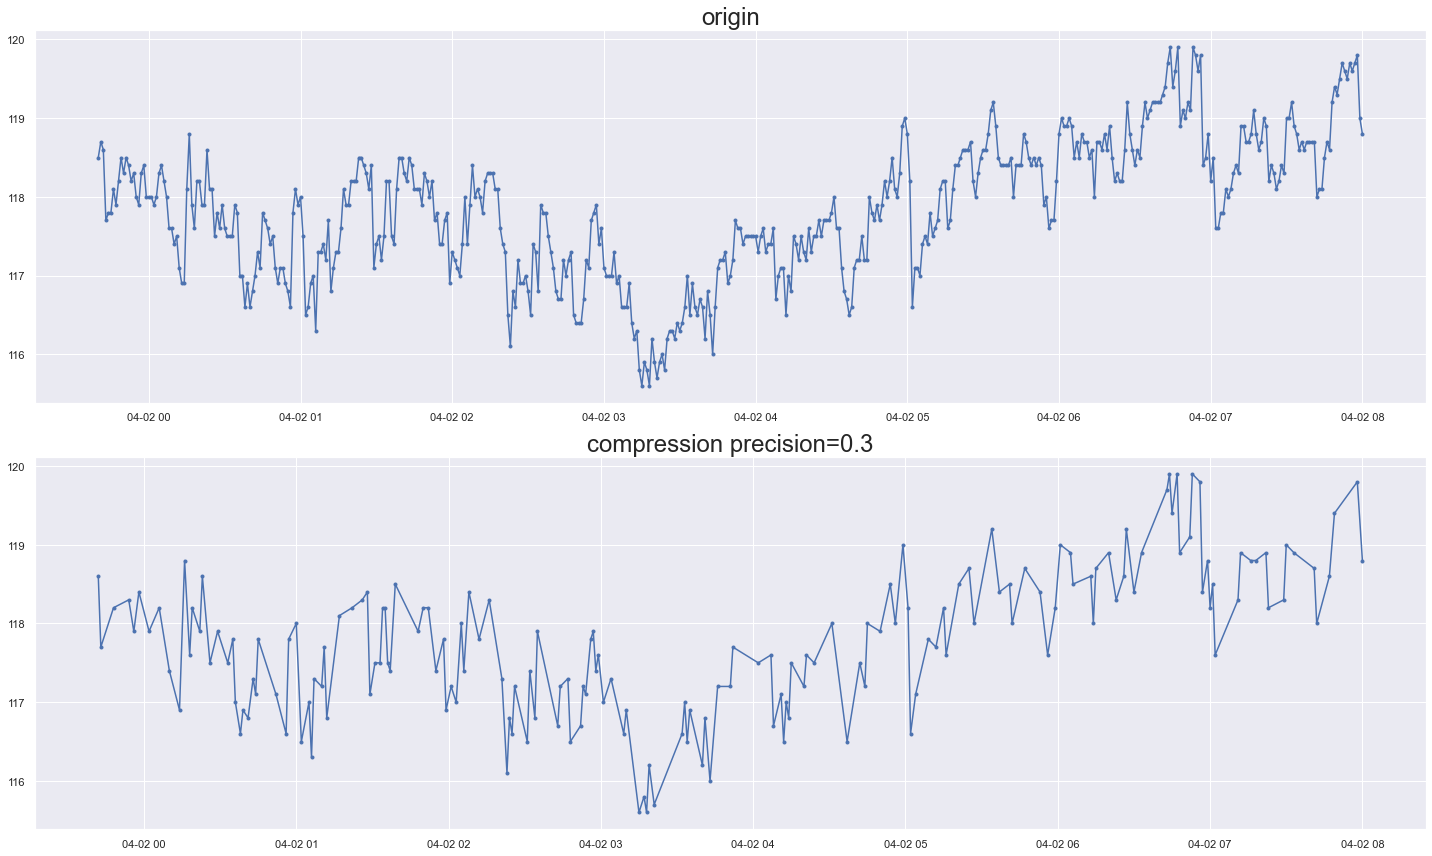

In [55]:
start_idx = 1000
end_idx = 1500
start_time = df_origin.loc[start_idx, 'timestamp'].strftime('%Y-%m-%d %H:%M:%S')
end_time = df_origin.loc[end_idx, 'timestamp'].strftime('%Y-%m-%d %H:%M:%S')

stmt_select = (
    f"SELECT timestamp, value FROM voltage\n"
    f"WHERE timestamp >= '{start_time}'\n"
    f"AND timestamp <= '{end_time}';"
)
mysql_cursor.execute(stmt_select)

data_compress = mysql_cursor.fetchall()
df_compress = pd.DataFrame(data_compress)
df_compress.columns = ['timestamp', 'voltage']

fig, axes = plt.subplots(2, 1, figsize=(20, 12))
axes[0].plot(df_origin.loc[start_idx:end_idx, 'timestamp'], df_origin.loc[start_idx:end_idx, 'V'], '.-')
axes[0].set_title("origin", fontsize=24)

axes[1].plot(df_compress['timestamp'], df_compress['voltage'], '.-')
axes[1].set_title(f"compression precision={dev_margin}", fontsize=24)
plt.tight_layout()
# plt.savefig(f"compare_2_{dev_margin}.png")

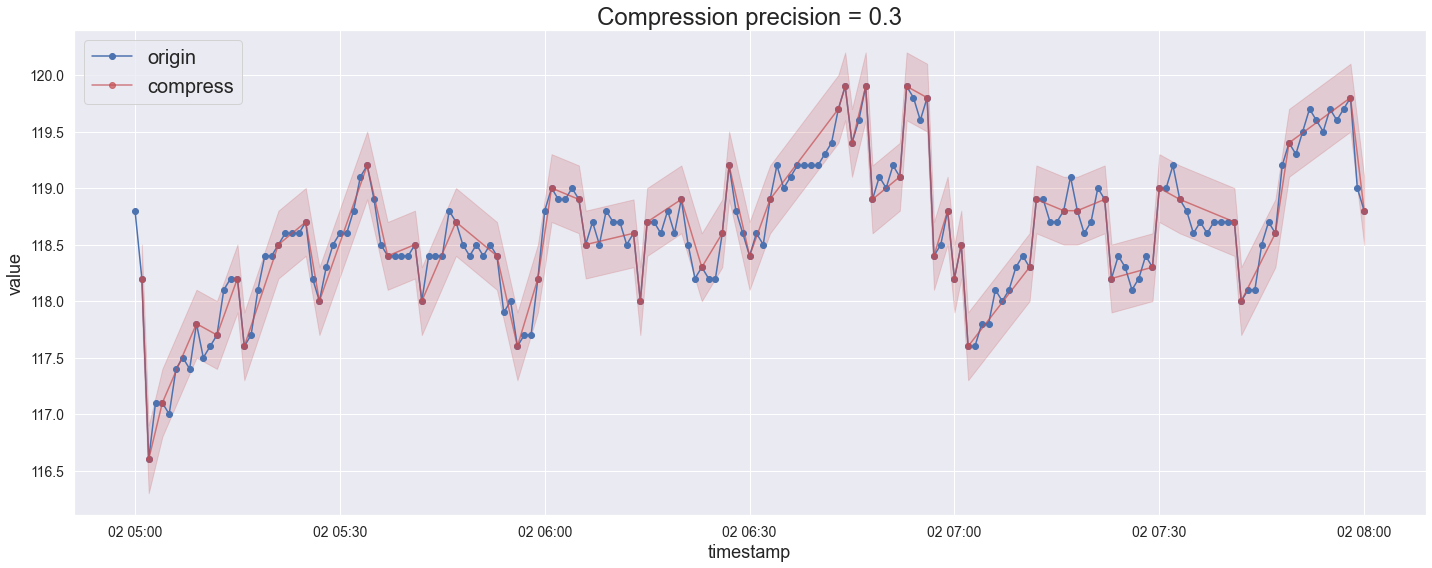

In [56]:
start_time = '2012-04-02 05:00:00'
end_time = '2012-04-02 08:00:00'
mask_origin = (df_origin['timestamp'] >= start_time) & (df_origin['timestamp'] <= end_time)
mask_comp = (df_compress['timestamp'] >= start_time) & (df_compress['timestamp'] <= end_time)

df_compress['upper'] = df_compress['voltage'] + dev_margin
df_compress['lower'] = df_compress['voltage'] - dev_margin

plt.figure(figsize=(20, 8))
plt.plot(df_origin.loc[mask_origin, 'timestamp'], df_origin.loc[mask_origin, 'V'],
         'bo-', label='origin', alpha=1)
plt.plot(df_compress.loc[mask_comp, 'timestamp'], df_compress.loc[mask_comp, 'voltage'],
         'ro-', label='compress', alpha=0.7)
plt.fill_between(df_compress.loc[mask_comp, 'timestamp'],
                 df_compress.loc[mask_comp, 'upper'],
                 df_compress.loc[mask_comp, 'lower'],
                 color='r', alpha=0.2)
plt.legend(fontsize=20, loc='upper left')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("timestamp", fontsize=18)
plt.ylabel("value", fontsize=18)
plt.title(f"Compression precision = {dev_margin}", fontsize=24)
plt.tight_layout()
# plt.savefig(f"compare_stack_{dev_margin}_compress.png")

# 5. SELECT a range by our connector and check the max compression error

In [57]:
start_idx, end_idx = 500, 7000
start_time = df_origin.loc[start_idx, 'timestamp'].strftime('%Y-%m-%d %H:%M:%S')
end_time = df_origin.loc[end_idx, 'timestamp'].strftime('%Y-%m-%d %H:%M:%S')

stmt_select = (
    f"SELECT timestamp, value FROM voltage\n"
    f"WHERE timestamp >= '{start_time}'\n"
    f"AND timestamp <= '{end_time}';"
)
ourcursor.execute(stmt_select)

data_reconstruct = ourcursor.fetchall()
df_reconstruct = pd.DataFrame(data_reconstruct)
df_reconstruct.columns = ['timestamp', 'voltage']

origin_voltage = df_origin.loc[start_idx:end_idx, 'V'].to_numpy()
reconstruct_voltage = df_reconstruct.loc[:, 'voltage'].to_numpy()
reconstruct_error = abs(origin_voltage - reconstruct_voltage)

print("precision setting =", dev_margin)
print("max_abs_error =", reconstruct_error.max())

precision setting = 0.3
max_abs_error = 0.29999999999999716


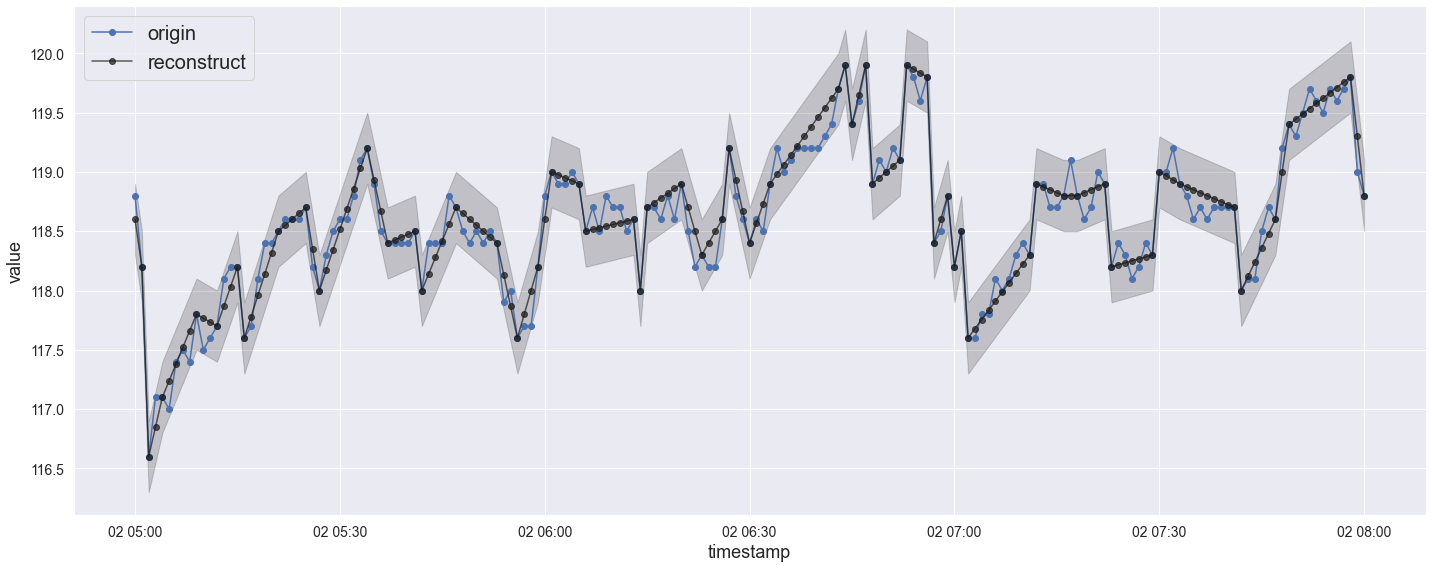

In [58]:
start_time = '2012-04-02 05:00:00'
end_time = '2012-04-02 08:00:00'
mask_origin = (df_origin['timestamp'] >= start_time) & (df_origin['timestamp'] <= end_time)
mask_comp = (df_reconstruct['timestamp'] >= start_time) & (df_reconstruct['timestamp'] <= end_time)

df_reconstruct['upper'] = df_reconstruct['voltage'] + dev_margin
df_reconstruct['lower'] = df_reconstruct['voltage'] - dev_margin

plt.figure(figsize=(20, 8))
plt.plot(df_origin.loc[mask_origin, 'timestamp'], df_origin.loc[mask_origin, 'V'],
         'bo-', label='origin', alpha=1)
plt.plot(df_reconstruct.loc[mask_comp, 'timestamp'], df_reconstruct.loc[mask_comp, 'voltage'],
         'ko-', label='reconstruct', alpha=0.7)
plt.fill_between(df_reconstruct.loc[mask_comp, 'timestamp'],
                 df_reconstruct.loc[mask_comp, 'upper'],
                 df_reconstruct.loc[mask_comp, 'lower'],
                 color='k', alpha=0.2)
plt.legend(fontsize=20, loc='upper left')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("timestamp", fontsize=18)
plt.ylabel("value", fontsize=18)
plt.tight_layout()
# plt.savefig(f"compare_stack_{dev_margin}_reconstruct.png")

# Other statement using our connector

In [59]:
mysql_cursor.close()
mysql_db.close()

In [60]:
ourcursor.execute('DROP DATABASE AMPds')
ourcursor.close()
ourdb.close()